### Stock Prediction using Linear Regression, XGBoost & LSTM

In this notebook, we will only consider the effect of previous many days of close prices as a input. As the best feature is the previous day prices, we will lag the data and try to tune the lookback days for improving the predictions. 

We will implement 3 more machine learning models 
1. Linear regression
3. XGBoost
4. LSTM

This is a Step by Step code to train 4 different algorithm to better understand how to go about implementing time series forcasting. 
This will help us in creating an entire Pipeline in object oriented approach. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

os.chdir(r'N:\STOCK ADVISOR BOT')


In [3]:
Stock = pd.read_csv('JPM.csv',  index_col=0)
#best features
features_selected = ['Open','High', 'Low','Close(t)', 'QQQ_Close', 'SnP_Close']

df_Stock = Stock[features_selected]
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})
df_Stock.head()

Open     High     Low  Close  QQQ_Close  SnP_Close
Date                                                           
2004-10-18  38.55  39.1100  38.530  39.00      36.14    1114.02
2004-10-19  38.75  39.3800  37.790  37.98      35.88    1103.23
2004-10-20  36.70  37.4500  36.321  37.25      36.05    1103.66
2004-10-21  37.08  37.8500  37.050  37.70      36.60    1106.49
2004-10-22  37.80  37.8776  37.400  37.47      35.80    1095.74

In [4]:
df_Stock = df_Stock.copy()
df_Stock['Diff'] = df_Stock['Close'] - df_Stock['Open']
df_Stock['High-low'] = df_Stock['High'] - df_Stock['Low']

features_selected = ['Close', 'QQQ_Close', 'SnP_Close', 'Diff', 'High-low']


In [5]:
df_Stock = df_Stock[features_selected]
df_Stock.head()

Close  QQQ_Close  SnP_Close  Diff  High-low
Date                                                   
2004-10-18  39.00      36.14    1114.02  0.45    0.5800
2004-10-19  37.98      35.88    1103.23 -0.77    1.5900
2004-10-20  37.25      36.05    1103.66  0.55    1.1290
2004-10-21  37.70      36.60    1106.49  0.62    0.8000
2004-10-22  37.47      35.80    1095.74 -0.33    0.4776

In [6]:
def prepare_lagged_features(df_Stock, lag_stock, lag_index, lag_diff):
    
    lags = range(1, lag_stock+1)
    lag_cols= ['Close']
    df_Stock=df_Stock.assign(**{
        '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
        for l in lags
        for col in lag_cols
    })
    
   # df_Stock = df_Stock.drop(columns=[''])
    
    
    lags = range(1, lag_index+1)
    lag_cols= ['QQQ_Close','SnP_Close']
    df_Stock=df_Stock.assign(**{
        '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
        for l in lags
        for col in lag_cols
    })
    
    df_Stock = df_Stock.drop(columns=lag_cols)
    
    
    lags = range(1, lag_diff+1)
    lag_cols= ['Diff','High-low']
    df_Stock=df_Stock.assign(**{
        '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
        for l in lags
        for col in lag_cols
    })
    
    df_Stock = df_Stock.drop(columns=lag_cols)
    
    remove_lags_na = max(lag_stock, lag_index, lag_diff) + 1
    print('Removing NAN rows - ', str(remove_lags_na))
    df_Stock = df_Stock.iloc[remove_lags_na:,]
    
    return df_Stock

In [7]:
df_Stock_lagged = prepare_lagged_features(df_Stock, lag_stock = 20, lag_index = 10, lag_diff = 5)

print(df_Stock_lagged.columns)
df_Stock_lagged.head(25)

Removing NAN rows -  21
Index(['Close', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)', 'Close(t-4)',
       'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)', 'Close(t-9)',
       'Close(t-10)', 'Close(t-11)', 'Close(t-12)', 'Close(t-13)',
       'Close(t-14)', 'Close(t-15)', 'Close(t-16)', 'Close(t-17)',
       'Close(t-18)', 'Close(t-19)', 'Close(t-20)', 'QQQ_Close(t-1)',
       'SnP_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)', 'QQQ_Close(t-3)',
       'SnP_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)', 'QQQ_Close(t-5)',
       'SnP_Close(t-5)', 'QQQ_Close(t-6)', 'SnP_Close(t-6)', 'QQQ_Close(t-7)',
       'SnP_Close(t-7)', 'QQQ_Close(t-8)', 'SnP_Close(t-8)', 'QQQ_Close(t-9)',
       'SnP_Close(t-9)', 'QQQ_Close(t-10)', 'SnP_Close(t-10)', 'Diff(t-1)',
       'High-low(t-1)', 'Diff(t-2)', 'High-low(t-2)', 'Diff(t-3)',
       'High-low(t-3)', 'Diff(t-4)', 'High-low(t-4)', 'Diff(t-5)',
       'High-low(t-5)'],
      dtype='object')


Close  Close(t-1)  Close(t-2)  Close(t-3)  Close(t-4)  Close(t-5)  \
Date                                                                            
2004-11-16  38.47       39.16       39.17       39.18       38.95       39.11   
2004-11-17  38.27       38.47       39.16       39.17       39.18       38.95   
2004-11-18  37.82       38.27       38.47       39.16       39.17       39.18   
2004-11-19  37.42       37.82       38.27       38.47       39.16       39.17   
2004-11-22  37.55       37.42       37.82       38.27       38.47       39.16   
2004-11-23  37.56       37.55       37.42       37.82       38.27       38.47   
2004-11-24  37.70       37.56       37.55       37.42       37.82       38.27   
2004-11-26  37.69       37.70       37.56       37.55       37.42       37.82   
2004-11-29  37.31       37.69       37.70       37.56       37.55       37.42   
2004-11-30  37.65       37.31       37.69       37.70       37.56       37.55   
2004-12-01  38.28       37.65       37.31       37.69       37.70       37.56   
2004-12-02  38.44       38.28       37.65       37.31       37.69       37.70   
2004-12-03  38.06       38.44       38.28       37.65       37.31       37.69   
2004-12-06  38.12       38.06       38.44       38.28       37.65       37.31   
2004-12-07  37.81       38.12       38.06       38.44       38.28       37.65   
2004-12-08  37.55       37.81       38.12       38.06       38.44       38.28   
2004-12-09  37.69       37.55       37.81       38.12       38.06       38.44   
2004-12-10  37.63       37.69       37.55       37.81       38.12       38.06   
2004-12-13  38.25       37.63       37.69       37.55       37.81       38.12   
2004-12-14  38.74       38.25       37.63       37.69       37.55       37.81   
2004-12-15  39.03       38.74       38.25       37.63       37.69       37.55   
2004-12-16  38.93       39.03       38.74       38.25       37.63       37.69   
2004-12-17  38.52       38.93       39.03       38.74       38.25       37.63   
2004-12-20  38.60       38.52       38.93       39.03       38.74       38.25   
2004-12-21  39.07       38.60       38.52       38.93       39.03       38.74   

            Close(t-6)  Close(t-7)  Close(t-8)  Close(t-9)  ...  Diff(t-1)  \
Date                                                        ...              
2004-11-16       39.28       39.35       39.64       38.85  ...       0.16   
2004-11-17       39.11       39.28       39.35       39.64  ...      -0.03   
2004-11-18       38.95       39.11       39.28       39.35  ...      -0.23   
2004-11-19       39.18       38.95       39.11       39.28  ...      -0.38   
2004-11-22       39.17       39.18       38.95       39.11  ...      -0.48   
2004-11-23       39.16       39.17       39.18       38.95  ...       0.13   
2004-11-24       38.47       39.16       39.17       39.18  ...      -0.09   
2004-11-26       38.27       38.47       39.16       39.17  ...      -0.08   
2004-11-29       37.82       38.27       38.47       39.16  ...      -0.01   
2004-11-30       37.42       37.82       38.27       38.47  ...      -0.38   
2004-12-01       37.55       37.42       37.82       38.27  ...       0.47   
2004-12-02       37.56       37.55       37.42       37.82  ...       0.48   
2004-12-03       37.70       37.56       37.55       37.42  ...       0.19   
2004-12-06       37.69       37.70       37.56       37.55  ...      -0.32   
2004-12-07       37.31       37.69       37.70       37.56  ...       0.17   
2004-12-08       37.65       37.31       37.69       37.70  ...      -0.39   
2004-12-09       38.28       37.65       37.31       37.69  ...      -0.26   
2004-12-10       38.44       38.28       37.65       37.31  ...       0.44   
2004-12-13       38.06       38.44       38.28       37.65  ...      -0.03   
2004-12-14       38.12       38.06       38.44       38.28  ...       0.25   
2004-12-15       37.81       38.12       38.06       38.44  ...       0.42   
2004-12-16       37.55       3

In [8]:
df_Stock = df_Stock_lagged
df_Stock.shape

(3875, 51)

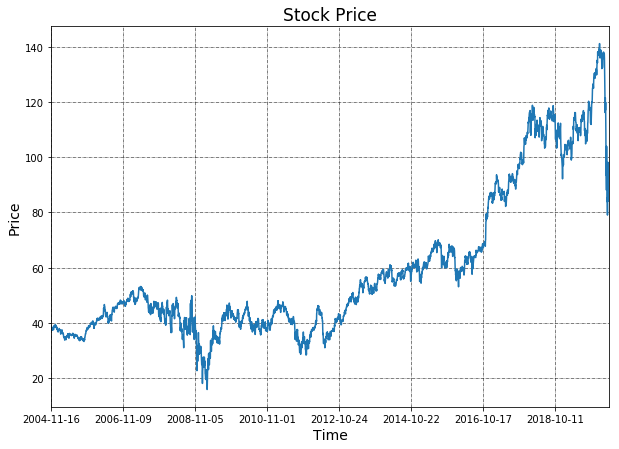

In [9]:
df_Stock['Close'].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [61]:
def create_train_test_set(df_Stock):
    
    df_Stock = df_Stock[:-30]
    features = df_Stock.drop(columns=['Close'], axis=1)
    target = df_Stock['Close']
    

    data_len = df_Stock.shape[0]
    print('Historical Stock Data length is - ', str(data_len))

    #create a chronological split for train and testing
    train_split = int(data_len * 0.88)
    print('Training Set length - ', str(train_split))

    val_split = train_split + int(data_len * 0.1)
    print('Validation Set length - ', str(int(data_len * 0.1)))

    print('Test Set length - ', str(int(data_len * 0.02)))

    # Splitting features and target into train, validation and test samples 
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    #print shape of samples
    print(X_train.shape, X_val.shape, X_test.shape)
    print(Y_train.shape, Y_val.shape, Y_test.shape)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [62]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = create_train_test_set(df_Stock)

Historical Stock Data length is -  3845
Training Set length -  3383
Validation Set length -  384
Test Set length -  76
(3383, 50) (384, 50) (78, 50)
(3383,) (384,) (78,)


### Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
print('LR Coefficients: \n', lr.coef_)
print('LR Intercept: \n', lr.intercept_)

LR Coefficients: 
 [ 1.01498376e+00 -5.83723661e-02 -2.85129084e-02  6.90369215e-02
  2.85240973e-03 -7.00725926e-02  6.21425968e-02  3.12018578e-02
  1.61083992e-02 -3.21957547e-02 -3.53224986e-02  4.37226520e-03
  8.81393784e-03 -2.63556968e-02  1.69483195e-02  4.84697149e-02
 -5.18875705e-03 -5.22203430e-02 -7.20629444e-04  2.76041102e-02
  1.38226424e-01 -1.15417351e-02 -1.85852452e-01  1.28453801e-02
  4.43705483e-02  2.12218025e-03 -9.29770013e-04 -1.92769627e-03
  2.18568349e-02 -2.90492690e-03 -5.28196961e-02  5.76264350e-03
  7.63500684e-02 -5.03075672e-03 -1.02944251e-01  1.12795740e-03
  8.34729809e-02 -5.19942659e-03 -1.87264063e-02  4.81263366e-03
 -6.72307538e-02  2.28140298e-03  4.16139387e-03  5.73501569e-02
  4.83620721e-02  8.35904119e-02 -4.82460138e-02 -2.61396561e-02
 -4.60028208e-02 -8.06425980e-02]
LR Intercept: 
 -0.0009187445617939716


In [65]:
print("Performance (R^2): ", lr.score(X_train, Y_train))

Performance (R^2):  0.9973047458771007


In [31]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [67]:
Y_train_pred = lr.predict(X_train)
Y_val_pred = lr.predict(X_val)
Y_test_pred = lr.predict(X_test)


print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

print(' ')

print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

Training R-squared:  1.0
Training Explained Variation:  1.0
Training MAPE: 1.43
Training Mean Squared Error: 0.93
Training RMSE:  0.97
Training MAE:  0.65
 
Validation R-squared:  0.94
Validation Explained Variation:  0.94
Validation MAPE: 0.97
Validation Mean Squared Error: 0.93
Validation RMSE:  1.41
Validation MAE:  1.06
 
Test R-squared:  0.83
Test Explained Variation:  0.83
Test MAPE: 0.78
Test Mean Squared Error: 2.25
Test RMSE:  1.5
Test MAE:  1.05


In [69]:
df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
df_pred['Predicted'] = Y_val_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred

Date  Actual   Predicted
0   2018-04-26  110.10  110.243844
1   2018-04-27  109.40  109.889315
2   2018-04-30  108.78  108.971568
3   2018-05-01  108.78  108.977622
4   2018-05-02  107.92  109.396390
..         ...     ...         ...
379 2019-10-28  126.51  126.147125
380 2019-10-29  126.43  126.364246
381 2019-10-30  125.73  125.980655
382 2019-10-31  124.92  125.514802
383 2019-11-01  127.80  125.302492

[384 rows x 3 columns]

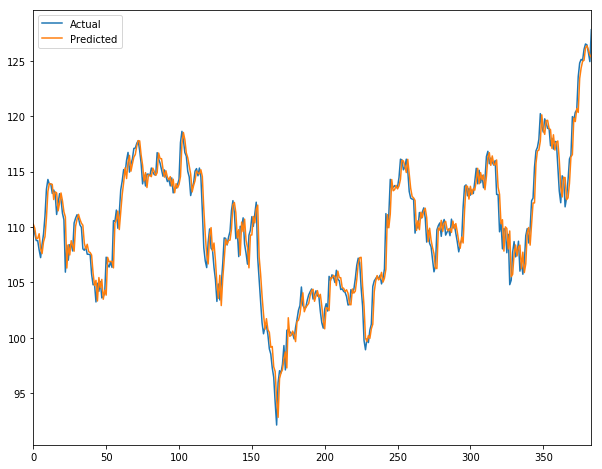

In [70]:
df_pred[['Actual', 'Predicted']].plot()

### XGBoost

In [71]:
from xgboost import XGBRegressor

In [75]:
n_estimators = 200             # Number of boosted trees to fit. default = 100
max_depth = 30                 # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 42

In [76]:
xgb = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [77]:
Y_train_pred = xgb.predict(X_train)
Y_val_pred = xgb.predict(X_val)
Y_test_pred = xgb.predict(X_test)


print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

print(' ')

print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

Training R-squared:  1.0
Training Explained Variation:  1.0
Training MAPE: 0.0
Training Mean Squared Error: 0.0
Training RMSE:  0.0
Training MAE:  0.0
 
Validation R-squared:  0.6
Validation Explained Variation:  0.61
Validation MAPE: 2.49
Validation Mean Squared Error: 0.0
Validation RMSE:  3.76
Validation MAE:  2.79
 
Test R-squared:  -44.77
Test Explained Variation:  -0.07
Test MAPE: 17.79
Test Mean Squared Error: 591.09
Test RMSE:  24.31
Test MAE:  24.03


In [78]:
df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
df_pred['Predicted'] = Y_val_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred

Date  Actual   Predicted
0   2018-04-26  110.10  110.686745
1   2018-04-27  109.40  110.633972
2   2018-04-30  108.78  111.040947
3   2018-05-01  108.78  110.267982
4   2018-05-02  107.92  109.803986
..         ...     ...         ...
379 2019-10-28  126.51  112.024857
380 2019-10-29  126.43  112.190842
381 2019-10-30  125.73  111.840965
382 2019-10-31  124.92  111.898407
383 2019-11-01  127.80  111.888481

[384 rows x 3 columns]

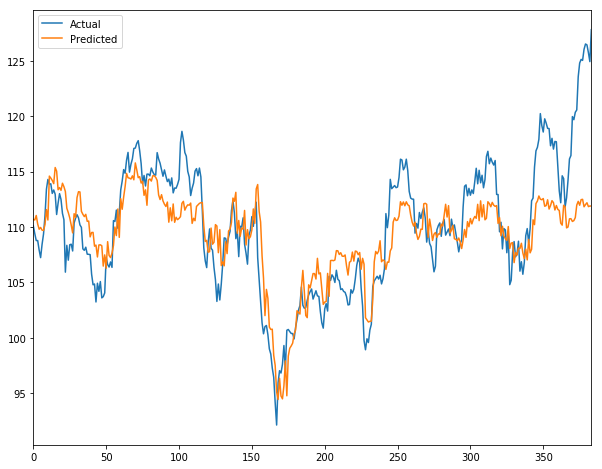

In [79]:
df_pred[['Actual', 'Predicted']].plot()

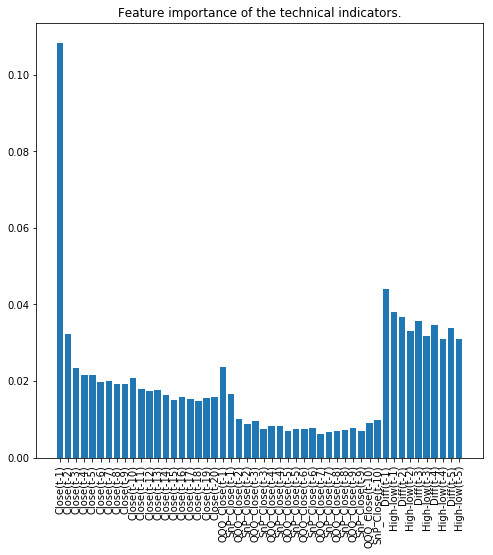

In [80]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb.feature_importances_))], xgb.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Feature importance of the technical indicators.')
plt.show()

### Random Forest 

In [83]:
rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=42)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [84]:
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
Y_test_pred = rf.predict(X_test)


print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

print(' ')

print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

Training R-squared:  1.0
Training Explained Variation:  1.0
Training MAPE: 0.57
Training Mean Squared Error: 0.15
Training RMSE:  0.39
Training MAE:  0.26
 
Validation R-squared:  0.72
Validation Explained Variation:  0.73
Validation MAPE: 2.09
Validation Mean Squared Error: 0.15
Validation RMSE:  3.11
Validation MAE:  2.3
 
Test R-squared:  -29.79
Test Explained Variation:  -0.02
Test MAPE: 14.51
Test Mean Squared Error: 397.58
Test RMSE:  19.94
Test MAE:  19.61


In [85]:
df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
df_pred['Predicted'] = Y_val_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred

Date  Actual  Predicted
0   2018-04-26  110.10   110.6793
1   2018-04-27  109.40   110.2880
2   2018-04-30  108.78   110.0301
3   2018-05-01  108.78   110.3179
4   2018-05-02  107.92   110.2141
..         ...     ...        ...
379 2019-10-28  126.51   115.6013
380 2019-10-29  126.43   115.5034
381 2019-10-30  125.73   114.5381
382 2019-10-31  124.92   115.4687
383 2019-11-01  127.80   115.4860

[384 rows x 3 columns]

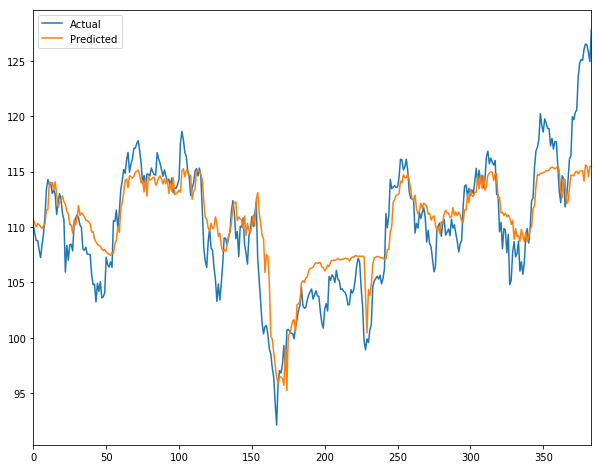

In [86]:
df_pred[['Actual', 'Predicted']].plot()

### LSTM (Long Short Term Memory)

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
df_Stock

Close  Close(t-1)  Close(t-2)  Close(t-3)  Close(t-4)  Close(t-5)  \
Date                                                                            
2004-11-16  38.47       39.16       39.17       39.18       38.95       39.11   
2004-11-17  38.27       38.47       39.16       39.17       39.18       38.95   
2004-11-18  37.82       38.27       38.47       39.16       39.17       39.18   
2004-11-19  37.42       37.82       38.27       38.47       39.16       39.17   
2004-11-22  37.55       37.42       37.82       38.27       38.47       39.16   
...           ...         ...         ...         ...         ...         ...   
2020-04-02  87.51       84.36       90.03       93.50       91.13       98.12   
2020-04-03  84.05       87.51       84.36       90.03       93.50       91.13   
2020-04-06  89.46       84.05       87.51       84.36       90.03       93.50   
2020-04-07  90.64       89.46       84.05       87.51       84.36       90.03   
2020-04-08  94.30       90.64       89.46       84.05       87.51       84.36   

            Close(t-6)  Close(t-7)  Close(t-8)  Close(t-9)  ...  Diff(t-1)  \
Date                                                        ...              
2004-11-16       39.28       39.35       39.64       38.85  ...       0.16   
2004-11-17       39.11       39.28       39.35       39.64  ...      -0.03   
2004-11-18       38.95       39.11       39.28       39.35  ...      -0.23   
2004-11-19       39.18       38.95       39.11       39.28  ...      -0.38   
2004-11-22       39.17       39.18       38.95       39.11  ...      -0.48   
...                ...         ...         ...         ...  ...        ...   
2020-04-02       91.73       88.43       79.03       83.50  ...      -0.74   
2020-04-03       98.12       91.73       88.43       79.03  ...       4.00   
2020-04-06       91.13       98.12       91.73       88.43  ...      -1.95   
2020-04-07       93.50       91.13       98.12       91.73  ...       0.47   
2020-04-08       90.03       93.50       91.13       98.12  ...      -3.81   

            High-low(t-1)  Diff(t-2)  High-low(t-2)  Diff(t-3)  High-low(t-3)  \
Date                                                                            
2004-11-16           0.21       0.24           0.39      -0.02           0.55   
2004-11-17           0.36       0.16           0.21       0.24           0.39   
2004-11-18           0.71      -0.03           0.36       0.16           0.21   
2004-11-19           0.55      -0.23           0.71      -0.03           0.36   
2004-11-22           0.71      -0.38           0.55      -0.23           0.71   
...                   ...        ...            ...        ...            ...   
2020-04-02           3.31      -2.02           4.83       2.85           4.79   
2020-04-03           4.95      -0.74           3.31      -2.02           4.83   
2020-04-06           4.71       4.00           4.95      -0.74           3.31   
2020-04-07           3.29      -1.95           4.71       4.00           4.95   
2020-04-08           4.12       0.47           3.29      -1.95           4.71   

            Diff(t-4)  High-low(t-4)  Diff(t-5)  High-low(t-5)  
Date                                                            
2004-11-16      -0.23           0.34      -0.22         0.4300  
2004-11-17      -0.02           0.55      -0.23         0.3400  
2004-11-18       0.24           0.39      -0.02         0.5500  
2004-11-19       0.16           0.21       0.24         0.3900  
2004-11-22      -0.03           0.36       0.16         0.2100  
...               ...            ...        ...            ...  
2020-04-02      -2.06           4.29       4.04         5.0325  
2020-04-03       2.85           4.79      -2.06         4.2900  
2020-04-06      -2.02           4.83       2.85         4.7900  
2020-04-07      -0.74           3.31      -2.02         4.8300  
2020-04-08       4.00           4.95      -0.74         3.3100  

[3875 rows x 51 columns]

In [12]:
features = df_Stock.drop(columns=['Close'], axis=1)
target = df_Stock['Close']

In [13]:
target = target.values.reshape(-1,1)
target

array([[38.47],
       [38.27],
       [37.82],
       ...,
       [89.46],
       [90.64],
       [94.3 ]])

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
features_SS = scaler.fit_transform(features)
features_SS

array([[0.18579759, 0.18587747, 0.18595734, ..., 0.02645914, 0.41981468,
        0.03346304],
       [0.18028597, 0.18579759, 0.18587747, ..., 0.04280156, 0.41910192,
        0.02645914],
       [0.17868839, 0.18028597, 0.18579759, ..., 0.03035019, 0.43406985,
        0.04280156],
       ...,
       [0.54437255, 0.57201054, 0.54684879, ..., 0.37587549, 0.6386315 ,
        0.37276265],
       [0.58758687, 0.54437255, 0.57201054, ..., 0.25758755, 0.29151818,
        0.37587549],
       [0.59701254, 0.58758687, 0.54437255, ..., 0.38521401, 0.38275125,
        0.25758755]])

In [15]:
scale_t = MinMaxScaler(feature_range=(0,1))
target_SS = scale_t.fit_transform(target)
target_SS

array([[0.18028597],
       [0.17868839],
       [0.17509386],
       ...,
       [0.58758687],
       [0.59701254],
       [0.6262481 ]])

In [16]:
features.columns

Index(['Close(t-1)', 'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)',
       'Close(t-6)', 'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)',
       'Close(t-11)', 'Close(t-12)', 'Close(t-13)', 'Close(t-14)',
       'Close(t-15)', 'Close(t-16)', 'Close(t-17)', 'Close(t-18)',
       'Close(t-19)', 'Close(t-20)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'QQQ_Close(t-2)', 'SnP_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'QQQ_Close(t-4)', 'SnP_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'QQQ_Close(t-6)', 'SnP_Close(t-6)', 'QQQ_Close(t-7)', 'SnP_Close(t-7)',
       'QQQ_Close(t-8)', 'SnP_Close(t-8)', 'QQQ_Close(t-9)', 'SnP_Close(t-9)',
       'QQQ_Close(t-10)', 'SnP_Close(t-10)', 'Diff(t-1)', 'High-low(t-1)',
       'Diff(t-2)', 'High-low(t-2)', 'Diff(t-3)', 'High-low(t-3)', 'Diff(t-4)',
       'High-low(t-4)', 'Diff(t-5)', 'High-low(t-5)'],
      dtype='object')

In [17]:
features_SS = pd.DataFrame(features_SS)
features_SS.columns = ['Close(t-1)', 'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)',
       'Close(t-6)', 'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)',
       'Close(t-11)', 'Close(t-12)', 'Close(t-13)', 'Close(t-14)',
       'Close(t-15)', 'Close(t-16)', 'Close(t-17)', 'Close(t-18)',
       'Close(t-19)', 'Close(t-20)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'QQQ_Close(t-2)', 'SnP_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'QQQ_Close(t-4)', 'SnP_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'QQQ_Close(t-6)', 'SnP_Close(t-6)', 'QQQ_Close(t-7)', 'SnP_Close(t-7)',
       'QQQ_Close(t-8)', 'SnP_Close(t-8)', 'QQQ_Close(t-9)', 'SnP_Close(t-9)',
       'QQQ_Close(t-10)', 'SnP_Close(t-10)', 'Diff(t-1)', 'High-low(t-1)',
       'Diff(t-2)', 'High-low(t-2)', 'Diff(t-3)', 'High-low(t-3)', 'Diff(t-4)',
       'High-low(t-4)', 'Diff(t-5)', 'High-low(t-5)']
features_SS

Close(t-1)  Close(t-2)  Close(t-3)  Close(t-4)  Close(t-5)  Close(t-6)  \
0       0.185798    0.185877    0.185957    0.184120    0.185398    0.186756   
1       0.180286    0.185798    0.185877    0.185957    0.184120    0.185398   
2       0.178688    0.180286    0.185798    0.185877    0.185957    0.184120   
3       0.175094    0.178688    0.180286    0.185798    0.185877    0.185957   
4       0.171899    0.175094    0.178688    0.180286    0.185798    0.185877   
...          ...         ...         ...         ...         ...         ...   
3870    0.546849    0.592140    0.619858    0.600927    0.656762    0.605719   
3871    0.572011    0.546849    0.592140    0.619858    0.600927    0.656762   
3872    0.544373    0.572011    0.546849    0.592140    0.619858    0.600927   
3873    0.587587    0.544373    0.572011    0.546849    0.592140    0.619858   
3874    0.597013    0.587587    0.544373    0.572011    0.546849    0.592140   

      Close(t-7)  Close(t-8)  Close(t-9)  Close(t-10)  ...  Diff(t-1)  \
0       0.187315    0.189632    0.183321     0.180925  ...   0.446900   
1       0.186756    0.187315    0.189632     0.183321  ...   0.433357   
2       0.185398    0.186756    0.187315     0.189632  ...   0.419102   
3       0.184120    0.185398    0.186756     0.187315  ...   0.408411   
4       0.185957    0.184120    0.185398     0.186756  ...   0.401283   
...          ...         ...         ...          ...  ...        ...   
3870    0.579359    0.504274    0.539979     0.554357  ...   0.382751   
3871    0.605719    0.579359    0.504274     0.539979  ...   0.720599   
3872    0.656762    0.605719    0.579359     0.504274  ...   0.296507   
3873    0.600927    0.656762    0.605719     0.579359  ...   0.468995   
3874    0.619858    0.600927    0.656762     0.605719  ...   0.163934   

      High-low(t-1)  Diff(t-2)  High-low(t-2)  Diff(t-3)  High-low(t-3)  \
0          0.016342   0.452602       0.030350   0.434070       0.042802   
1          0.028016   0.446900       0.016342   0.452602       0.030350   
2          0.055253   0.433357       0.028016   0.446900       0.016342   
3          0.042802   0.419102       0.055253   0.433357       0.028016   
4          0.055253   0.408411       0.042802   0.419102       0.055253   
...             ...        ...            ...        ...            ...   
3870       0.257588   0.291518       0.375875   0.638632       0.372763   
3871       0.385214   0.382751       0.257588   0.291518       0.375875   
3872       0.366537   0.720599       0.385214   0.382751       0.257588   
3873       0.256031   0.296507       0.366537   0.720599       0.385214   
3874       0.320623   0.468995       0.256031   0.296507       0.366537   

      Diff(t-4)  High-low(t-4)  Diff(t-5)  High-low(t-5)  
0      0.419102       0.026459   0.419815       0.033463  
1      0.434070       0.042802   0.419102       0.026459  
2      0.452602       0.030350   0.434070       0.042802  
3      0.446900       0.016342   0.452602       0.030350  
4      0.433357       0.028016   0.446900       0.016342  
...         ...            ...        ...            ...  
3870   0.288667       0.333852   0.723450       0.391634  
3871   0.638632       0.372763   0.288667       0.333852  
3872   0.291518       0.375875   0.638632       0.372763  
3873   0.382751       0.257588   0.291518       0.375875  
3874   0.720599       0.385214   0.382751       0.257588  

[3875 rows x 50 columns]

In [18]:
features_SS.values

array([[0.18579759, 0.18587747, 0.18595734, ..., 0.02645914, 0.41981468,
        0.03346304],
       [0.18028597, 0.18579759, 0.18587747, ..., 0.04280156, 0.41910192,
        0.02645914],
       [0.17868839, 0.18028597, 0.18579759, ..., 0.03035019, 0.43406985,
        0.04280156],
       ...,
       [0.54437255, 0.57201054, 0.54684879, ..., 0.37587549, 0.6386315 ,
        0.37276265],
       [0.58758687, 0.54437255, 0.57201054, ..., 0.25758755, 0.29151818,
        0.37587549],
       [0.59701254, 0.58758687, 0.54437255, ..., 0.38521401, 0.38275125,
        0.25758755]])

In [19]:
def create_train_test_LSTM(features_SS, target):
    
    features_SS = features_SS[:-30]
    target = target[:-30]
    
    features_SS = features_SS.values
    target = target
    

    data_len = features_SS.shape[0]
    print('Historical Stock Data length is - ', str(data_len))

    #create a chronological split for train and testing
    train_split = int(data_len * 0.87)
    print('Training Set length - ', str(train_split))

    print('Test Set length - ', str(int(data_len * 0.13)))

    
    # Splitting features and target into train and test samples 
    X_train, X_test = features_SS[:train_split], features_SS[train_split:]
    Y_train, Y_test = target[:train_split], target[train_split:]

    #print shape of samples
    print(X_train.shape, X_test.shape)
    print(Y_train.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


In [20]:
X_train, X_test, Y_train, Y_test = create_train_test_LSTM(features_SS, target_SS)

Historical Stock Data length is -  3845
Training Set length -  3345
Test Set length -  499
(3345, 50) (500, 50)
(3345, 1) (500, 1)


In [21]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(3345, 50, 1) (3345, 1) (500, 50, 1) (500, 1)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.optimizers import Adam

In [24]:
lstm = Sequential()
lstm.add(LSTM(64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2, input_shape=(X_train.shape[1],1)))
lstm.add(LSTM(32, recurrent_dropout=0.2, dropout=0.2))
lstm.add(Dense(1))

lstm.compile(loss='mean_squared_error',
             optimizer='adam', 
            metrics = ['mae'])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_lstm = lstm.fit(X_train, Y_train, batch_size=16, epochs=30, validation_data=(X_test, Y_test), shuffle=False)

Train on 3345 samples, validate on 500 samples
Epoch 1/30
3345/3345 [==============================] - 19s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0503 - val_loss: 0.0208 - val_mean_absolute_error: 0.1323
Epoch 2/30
3345/3345 [==============================] - 22s 7ms/step - loss: 0.0129 - mean_absolute_error: 0.0757 - val_loss: 0.0072 - val_mean_absolute_error: 0.0705
Epoch 3/30
3345/3345 [==============================] - 21s 6ms/step - loss: 0.0120 - mean_absolute_error: 0.0728 - val_loss: 0.0065 - val_mean_absolute_error: 0.0592
Epoch 4/30
3345/3345 [==============================] - 21s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0722 - val_loss: 0.0064 - val_mean_absolute_error: 0.0586
Epoch 5/30
3345/3345 [==============================] - 20s 6ms/step - loss: 0.0127 - mean_absolute_error: 0.0784 - val_loss: 0.0176 - val_mean_absolute_error: 0.1222
Epoch 6/30
3345/3345 [==============================] - 21s 6ms/step - loss: 0.0178 - mean_absolute_error: 0.0901 - va

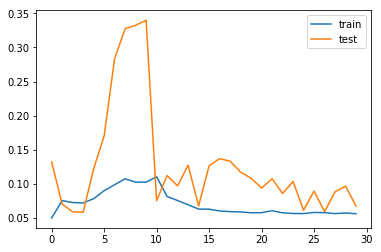

In [26]:
plt.plot(history_lstm.history['mean_absolute_error'], label='train')
plt.plot(history_lstm.history['val_mean_absolute_error'], label='test')
plt.legend()
plt.show()

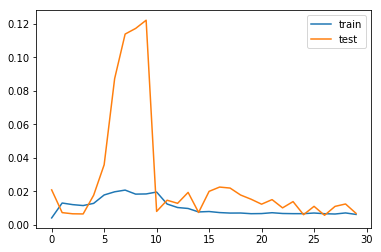

In [27]:
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend()
plt.show()

In [28]:
history_lstm.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [29]:
mae = lstm.evaluate(X_test, Y_test, batch_size=10)
print('Mean Absolute Error for Y:', mae)

500/500 [==============================] - 0s 959us/step
Mean Absolute Error for Y: [0.006753268552711233, 0.06770470841787755]


In [32]:
# Calculate MAPE
mape_pct = get_mape(Y_test, lstm.predict(X_test))
print("MAPE = %0.3f%%" % mape_pct)

MAPE = 8.344%


In [33]:
# PREDICTION
Ytrain_Predict = lstm.predict(X_train)
Ytest_Predict = lstm.predict(X_test)

Ytrain_Predict = scale_t.inverse_transform(Ytrain_Predict)
Y_train = scale_t.inverse_transform(Y_train)
Ytest_Predict = scale_t.inverse_transform(Ytest_Predict)
Y_test = scale_t.inverse_transform(Y_test)

In [34]:
'''
print("Training R-squared: ",round(metrics.r2_score(Y_train,Ytrain_Predict),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Ytrain_Predict),2))
print('Training MAPE:', round(get_mape(Y_train,Ytrain_Predict), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Ytrain_Predict), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Ytrain_Predict)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Ytrain_Predict),2))
'''
print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Ytest_Predict),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Ytest_Predict),2))
print('Test MAPE:', round(get_mape(Y_test,Ytest_Predict), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Ytest_Predict), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Ytest_Predict)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Ytest_Predict),2))

 
Test R-squared:  0.02
Test Explained Variation:  0.62
Test MAPE: 7.2
Test Mean Squared Error: 105.84
Test RMSE:  10.29
Test MAE:  8.48


In [35]:
df_pred = pd.DataFrame(Y_test, columns=['Actual'])
df_pred['Predicted'] = Ytest_Predict
df_pred = df_pred.reset_index()
#df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred

index  Actual   Predicted
0        0  113.32  100.130753
1        1  115.06  101.208290
2        2  115.16  100.007187
3        3  114.73   96.893440
4        4  114.74   97.470612
..     ...     ...         ...
495    495  137.49  124.512749
496    496  135.81  124.755775
497    497  132.16  124.454659
498    498  126.26  125.521622
499    499  126.64  124.591568

[500 rows x 3 columns]

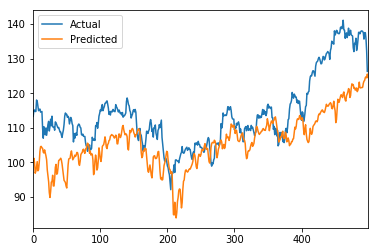

In [36]:
df_pred[['Actual', 'Predicted']].plot()

### Conclusion

Random Forest, XG Boost and Linear regression seems to work very well on such a long data as well. We have taken around 12-15 years of historical data which was divided into Training, Validation and Testing. 

These algorithms are able to catch the trend and move close to the Actual closing price in the right direction with a very low Mean Absolute error(MAE). The Evaluation Metrics is above to see how each algorithm performed on each stock. They worked so well because of the Feature Extraction we did to extract around 60 features including lagged Index funds prices, Technical Indicators like Exponential Moving Average, RSI, ADR, Willam's R, bollinger bands and many more. 

LSTMs followed the trend but did not perform well on price prediction as expected, as the data is not using any sequence of previous many time steps. and LSTM will work better on time series data once we provide it with previous 30-60 days of lookback data for every prediction. 
Thats what we will be doing in the next Notebooks and then we will move to Portfolio Optimization. 

### License
MIT License

Copyright (c) 2020 Avinash Chourasiya

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.